In [41]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score

import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D,Conv2D, Dense, Dropout
from tensorflow.keras.layers import MaxPool2D
from tcn import TCN, tcn_full_summary, compiled_tcn

#### TCN model on KGML Dataset

In [42]:
# Load KGML Data
kg_data = pd.read_csv('kg_complete.csv')

In [43]:
kg_data.head()

,PC1,PC2,Returns,StochK,WillR,RSI,Target
0,-0.107480,-0.064257,-0.035411,-0.016499,0.176882,0.001747,0
1,-0.187027,-0.032763,-1.456557,-0.016499,0.176882,0.001747,1
2,-0.161993,0.659205,0.650385,-0.016499,0.176882,0.001747,1
3,-0.092571,-0.108001,0.078413,-0.016499,0.176882,0.001747,0
4,-0.138446,0.066147,-1.181554,-0.016499,0.176882,0.001747,1


In [44]:
# Split dataset in features (X) and labels (y)
x = kg_data.drop(columns = ['Target'])
x = np.array(x)
y = np.ravel(kg_data['Target'])

In [45]:
f = x.reshape(x.shape[0], x.shape[1], 1)
l = y

In [46]:
f.shape, l.shape

((657, 6, 1), (657,))

In [47]:
# Split KG into training and test sets
x_train,x_test,y_train,y_test = train_test_split(f, l, test_size=0.2, 
                                                 random_state=42)

In [48]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((525, 6, 1), (132, 6, 1), (525,), (132,))

In [51]:
# Initialise model

i = Input(shape=(6,1), name='Input')
x = Conv1D(128,6,name='Conv1D_layer')(i)
x = TCN(nb_filters=64,
        kernel_size=6,
        dilations=[1, 2, 4, 8],
        nb_stacks=1,
        padding='causal',
        dropout_rate=0.2,
        activation='relu',
        #lr=0.002,
        name='TCN_layer')(x)
x = Dense(32, activation='relu', name='Dense_layer' )(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid', name='output')(x)

model = Model(inputs=[i], outputs=[x])
model.compile('adam', 'binary_crossentropy', metrics=['accuracy', 'mse'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 6, 1)]            0         
_________________________________________________________________
Conv1D_layer (Conv1D)        (None, 1, 128)            896       
_________________________________________________________________
TCN_layer (TCN)              (None, 64)                229952    
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 232,961
Trainable params: 232,961
Non-trainable params: 0
________________________________________________

In [52]:
model.fit(x_train, y_train, epochs = 100, verbose=1)

Epoch 1/100
17/17 [==============================] - 0s 9ms/step - loss: 0.6983 - accuracy: 0.5029 - mse: 0.2525
Epoch 2/100
17/17 [==============================] - 0s 9ms/step - loss: 0.6846 - accuracy: 0.5524 - mse: 0.2458
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 0.6816 - accuracy: 0.5486 - mse: 0.2443
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 0.6875 - accuracy: 0.5657 - mse: 0.2471
Epoch 5/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6852 - accuracy: 0.5524 - mse: 0.2459
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 0.6863 - accuracy: 0.5467 - mse: 0.2464
Epoch 7/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6791 - accuracy: 0.5524 - mse: 0.2431
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6808 - accuracy: 0.5543 - mse: 0.2439
Epoch 9/100
17/17 [==============================] - 0s 10ms/step - loss: 0.6735 - accuracy: 0

17/17 [==============================] - 0s 12ms/step - loss: 0.4896 - accuracy: 0.7562 - mse: 0.1623
Epoch 73/100
17/17 [==============================] - 0s 11ms/step - loss: 0.5017 - accuracy: 0.7524 - mse: 0.1678
Epoch 74/100
17/17 [==============================] - 0s 11ms/step - loss: 0.4782 - accuracy: 0.7600 - mse: 0.1582
Epoch 75/100
17/17 [==============================] - 0s 10ms/step - loss: 0.4819 - accuracy: 0.7467 - mse: 0.1634
Epoch 76/100
17/17 [==============================] - 0s 13ms/step - loss: 0.5012 - accuracy: 0.7410 - mse: 0.1673
Epoch 77/100
17/17 [==============================] - 0s 10ms/step - loss: 0.4757 - accuracy: 0.7562 - mse: 0.1574
Epoch 78/100
17/17 [==============================] - 0s 10ms/step - loss: 0.4471 - accuracy: 0.7600 - mse: 0.1475
Epoch 79/100
17/17 [==============================] - 0s 11ms/step - loss: 0.4727 - accuracy: 0.7543 - mse: 0.1568
Epoch 80/100
17/17 [==============================] - 0s 10ms/step - loss: 0.4766 - accuracy:

In [53]:
?model.save

In [54]:
pred = model.predict(x_test)
y_pred = np.where(pred <=0.5, 0, 1)

In [57]:
# Metrics
pred_accuracy = accuracy_score(y_test, y_pred)
fscore = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print('accuracy_score: %.3f' % pred_accuracy)
print('f1_score: %.3f' % fscore)
#print('roc_auc: %.3f' % roc_auc)

accuracy_score: 0.592
f1_score: 0.625


### TCN Model on TransE Dataset

In [11]:
# Load TransE Data
te_complete = pd.read_csv('te_complete.csv')

In [12]:
te_complete.head()

,ent1PC1,ent1PC2,ent2PC1,ent2PC2,Returns,StochK,WillR,RSI,Target
0,0.223980,0.260527,0.018174,0.220696,-0.035411,-0.016499,0.176882,0.001747,0
1,0.396025,0.123712,-0.033438,0.314318,-1.456557,-0.016499,0.176882,0.001747,1
2,-0.033738,0.145388,-0.001960,0.225625,0.650385,-0.016499,0.176882,0.001747,1
3,-0.061627,0.180608,0.041613,-0.137706,0.078413,-0.016499,0.176882,0.001747,0
4,0.147277,-0.237953,-0.321499,0.335000,-1.181554,-0.016499,0.176882,0.001747,1


In [265]:
# Split dataset in features (X) and labels (y)
xt = te_complete.drop(columns = ['Target'])
xt = np.array(xt)
yt = np.ravel(te_complete['Target'])

In [266]:
m = xt.reshape(xt.shape[0], xt.shape[1], 1)
n = yt

In [267]:
m.shape, n.shape

((657, 8, 1), (657,))

In [268]:
# Split KG into training and test sets
xt_train, xt_test, yt_train, yt_test = train_test_split(m, n, 
                                                        test_size=0.2,
                                                        random_state=42)

In [269]:
xt_train.shape, xt_test.shape, yt_train.shape, yt_test.shape

((525, 8, 1), (132, 8, 1), (525,), (132,))

In [322]:
# Initialise model

it = Input(shape=(8,1), name='Input')
xt = Conv1D(128,8,name='Conv1D_layer')(it)
xt = TCN(nb_filters=64,
        kernel_size=6,
        dilations=[1, 2, 4, 8],
        nb_stacks=1,
        padding='causal',
        dropout_rate=0.2,
        activation='relu',
        #lr=0.002,
        name='TCN_layer')(xt)
xt = Dense(32, activation='relu', name='Dense_layer' )(xt)
xt = Dropout(0.2)(xt)
xt = Dense(1, activation='sigmoid', name='output')(xt)

transE_model = Model(inputs=[it], outputs=[xt])
transE_model.compile('adam', 'binary_crossentropy', 
                     metrics=['accuracy', 'mse'])
transE_model.summary()

Model: "functional_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 8, 1)]            0         
_________________________________________________________________
Conv1D_layer (Conv1D)        (None, 1, 128)            1152      
_________________________________________________________________
TCN_layer (TCN)              (None, 64)                229952    
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                2080      
_________________________________________________________________
dropout_27 (Dropout)         (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 233,217
Trainable params: 233,217
Non-trainable params: 0
_______________________________________________

In [324]:
transE_model.fit(xt_train, yt_train, epochs = 100, verbose=1)

Epoch 1/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1883 - accuracy: 0.9352 - mse: 0.0507
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 0.1936 - accuracy: 0.9219 - mse: 0.0586
Epoch 3/100
17/17 [==============================] - 0s 20ms/step - loss: 0.1599 - accuracy: 0.9295 - mse: 0.0477
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1285 - accuracy: 0.9448 - mse: 0.0376
Epoch 5/100
17/17 [==============================] - 0s 22ms/step - loss: 0.1245 - accuracy: 0.9505 - mse: 0.0364
Epoch 6/100
17/17 [==============================] - 0s 22ms/step - loss: 0.1792 - accuracy: 0.9352 - mse: 0.0504
Epoch 7/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1938 - accuracy: 0.9200 - mse: 0.0585
Epoch 8/100
17/17 [==============================] - 0s 26ms/step - loss: 0.1716 - accuracy: 0.9295 - mse: 0.0503
Epoch 9/100
17/17 [==============================] - 0s 25ms/step - loss: 0.1527 - accur

In [325]:
tpred = transE_model.predict(xt_test)
yt_pred = np.where(tpred <=0.5, 0, 1)

In [327]:
# Metrics
pred_accuracy = accuracy_score(yt_test, yt_pred)
fscore = f1_score(yt_test, yt_pred)
roc_auc = roc_auc_score(yt_test, yt_pred)
print('accuracy_score: %.3f' % pred_accuracy)
print('f1_score: %.3f' % fscore)
#print('roc_auc: %.3f' % roc_auc)

accuracy_score: 0.608
f1_score: 0.639


### TCN Model on Baseline Dataset

In [62]:
# Load baseline data
bl_complete = pd.read_csv('bl_merged.csv')

In [63]:
bl_complete.head()

,Returns,StochK,WillR,RSI,Target
0,-0.035411,-0.016499,0.176882,0.001747,0
1,-1.456557,-0.016499,0.176882,0.001747,1
2,0.650385,-0.016499,0.176882,0.001747,1
3,0.078413,-0.016499,0.176882,0.001747,0
4,-1.181554,-0.016499,0.176882,0.001747,1


In [64]:
# Split dataset in features (X) and labels (y)
xb = bl_complete.drop(columns = ['Target'])
xb = np.array(xb)
yb = np.ravel(te_complete['Target'])

In [65]:
u = xb.reshape(xb.shape[0], xb.shape[1], 1)
v = yb

In [66]:
u.shape, v.shape

((657, 4, 1), (657,))

In [67]:
# Split KG into training and test sets
xb_train, xb_test, yb_train, yb_test = train_test_split(u, v, 
                                                        test_size=0.2,
                                                        random_state=42)

In [68]:
xb_train.shape, xb_test.shape, yb_train.shape, yb_test.shape

((525, 4, 1), (132, 4, 1), (525,), (132,))

In [69]:
# Initialise baseline model

ib = Input(shape=(4,1), name='Input')
xb = Conv1D(128,4,name='Conv1D_layer')(ib)
xb = TCN(nb_filters=64,
        kernel_size=6,
        dilations=[1, 2, 4, 8],
        nb_stacks=1,
        padding='causal',
        dropout_rate=0.2,
        activation='relu',
        #lr=0.002,
        name='TCN_layer')(xb)
xb = Dense(32, activation='relu', name='Dense_layer' )(xb)
xb = Dropout(0.2)(xb)
xb = Dense(1, activation='sigmoid', name='output')(xb)

bl_model = Model(inputs=[ib], outputs=[xb])
bl_model.compile('adam', 'binary_crossentropy', 
                     metrics=['accuracy', 'mse'])
bl_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 4, 1)]            0         
_________________________________________________________________
Conv1D_layer (Conv1D)        (None, 1, 128)            640       
_________________________________________________________________
TCN_layer (TCN)              (None, 64)                229952    
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 232,705
Trainable params: 232,705
Non-trainable params: 0
________________________________________________

In [70]:
bl_model.fit(xb_train, yb_train, epochs = 100, verbose=1)

Epoch 1/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5467 - mse: 0.2498
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6858 - accuracy: 0.5352 - mse: 0.2461
Epoch 3/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6828 - accuracy: 0.5848 - mse: 0.2448
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 0.6841 - accuracy: 0.5562 - mse: 0.2455
Epoch 5/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6786 - accuracy: 0.5543 - mse: 0.2429
Epoch 6/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6771 - accuracy: 0.5829 - mse: 0.2421
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 0.6785 - accuracy: 0.5505 - mse: 0.2428
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6777 - accuracy: 0.5848 - mse: 0.2421
Epoch 9/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6868 - accuracy: 0.5

17/17 [==============================] - 0s 11ms/step - loss: 0.5863 - accuracy: 0.6667 - mse: 0.2032
Epoch 73/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5630 - accuracy: 0.6952 - mse: 0.1938
Epoch 74/100
17/17 [==============================] - 0s 9ms/step - loss: 0.5713 - accuracy: 0.6952 - mse: 0.1965
Epoch 75/100
17/17 [==============================] - 0s 13ms/step - loss: 0.5688 - accuracy: 0.7029 - mse: 0.1943
Epoch 76/100
17/17 [==============================] - 0s 9ms/step - loss: 0.5819 - accuracy: 0.6857 - mse: 0.2003
Epoch 77/100
17/17 [==============================] - 0s 9ms/step - loss: 0.5638 - accuracy: 0.7295 - mse: 0.1926
Epoch 78/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5602 - accuracy: 0.6990 - mse: 0.1926
Epoch 79/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5616 - accuracy: 0.7181 - mse: 0.1910
Epoch 80/100
17/17 [==============================] - 0s 11ms/step - loss: 0.5584 - accuracy: 0.

In [71]:
bpred = bl_model.predict(xb_test)
yb_pred = np.where(bpred <=0.5, 0, 1)

In [75]:
# Metrics
bpred_accuracy = accuracy_score(yb_test, yb_pred)
bfscore = f1_score(yb_test, yb_pred)
broc_auc = roc_auc_score(yb_test, yb_pred)
print('accuracy_score: %.3f' % bpred_accuracy)
print('f1_score: %.3f' % bfscore)
#print('roc_auc: %.3f' % broc_auc)

accuracy_score: 0.607
f1_score: 0.600


### Plotting PCA

In [7]:
# KGML
kgml_pca = kg_data[['PC1', 'PC2', 'Target']].copy()

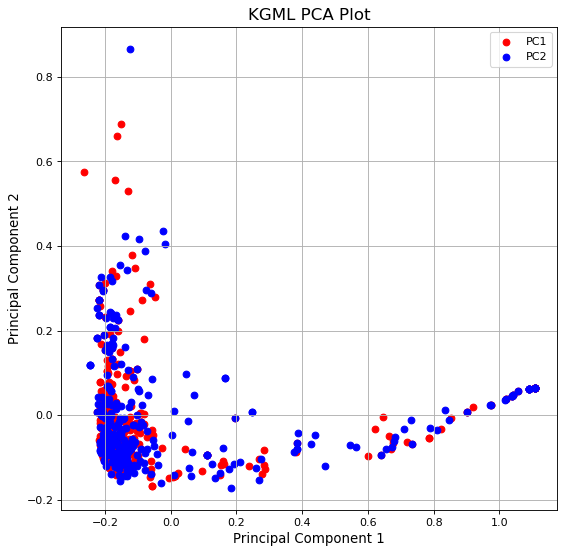

In [9]:
# PCA Plot
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

label = [1, 0]
colors = ['r', 'b']
for lbl, color in zip(label, colors):
    plt.scatter(kgml_pca.loc[kgml_pca['Target'] == lbl, 'PC1'], 
                kgml_pca.loc[kgml_pca['Target'] == lbl, 'PC2'], 
                c = color)
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('KGML PCA Plot', fontsize = 15)
plt.legend(['PC1', 'PC2'])
plt.grid()

In [25]:
# TransE
transe1_pca = te_complete[['ent1PC1', 'ent1PC2', 'Target']].copy()
transe2_pca = te_complete[['ent2PC1', 'ent2PC2', 'Target']].copy()

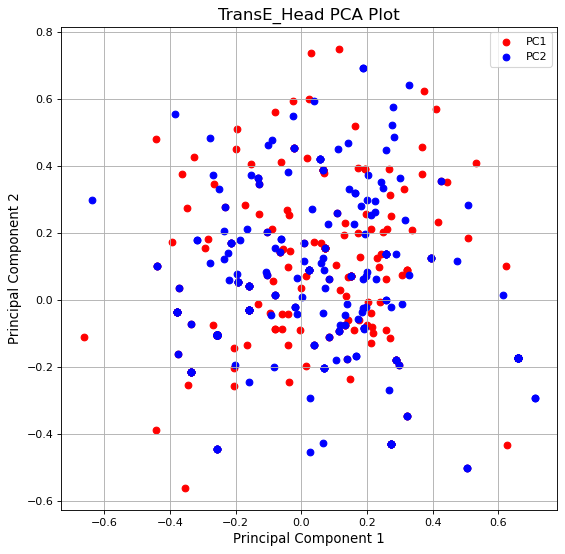

In [26]:
# PCA Plot
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

label = [1, 0]
colors = ['r', 'b']
for lbl, color in zip(label, colors):
    plt.scatter(transe1_pca.loc[transe1_pca['Target'] == lbl, 'ent1PC1'], 
                transe1_pca.loc[transe1_pca['Target'] == lbl, 'ent1PC2'], 
                c = color)
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('TransE_Head PCA Plot', fontsize = 15)
plt.legend(['PC1', 'PC2'])
plt.grid()

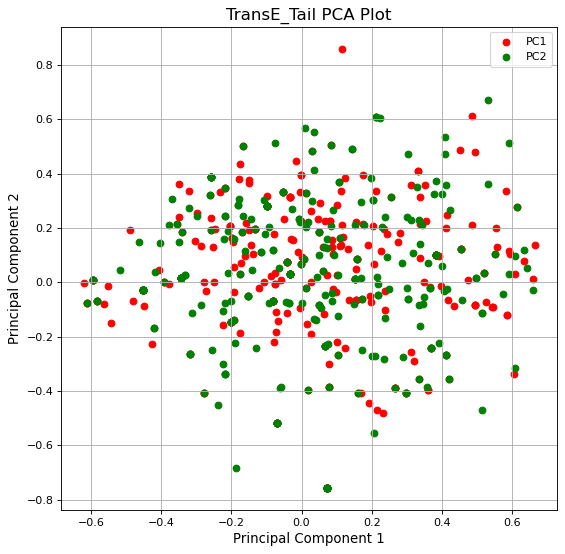

In [29]:
# PCA Plot
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

label = [1, 0]
colors = ['r', 'g']
for lbl, color in zip(label, colors):
    plt.scatter(transe2_pca.loc[transe2_pca['Target'] == lbl, 'ent2PC1'], 
                transe2_pca.loc[transe2_pca['Target'] == lbl, 'ent2PC2'], 
                c = color)
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('TransE_Tail PCA Plot', fontsize = 15)
plt.legend(['PC1', 'PC2'])
plt.grid()

In [32]:
?Dense

In [36]:
yes_values = transe2_pca.loc[transe2_pca['Target'] == 1]
no_values = transe2_pca.loc[transe2_pca['Target'] == 0]

In [37]:
len(yes_values), len(no_values)

(350, 307)

In [39]:
?Model.compile